# 锚框 (内容较多，需要仔细看)

最好能够f10。f11慢慢看算法做了什么

目标检测算法通常会在输入图像中采集大量的区域，然后判断这些区域中是否包含我们感兴趣的目标，并调整区域边界从而更加准确地预测目标的真实边界框（ground-truth bounding box）。不同模型使用的区域采样方式可能是不同的。

在这里使用的是：以每个像素为中心，生成多个缩放比和宽高比(aspect ratio)不同的边界框。这些边界框被称为锚框。

在CV这一节中将要实现一个基于锚框的检测模型。

## 生成多个锚框
如果输入图像的高度为$h$，宽度为$w$，我们以图像的每个像素为中心生成不同的锚框：

缩放比为$s \in (0,1]$，宽高比为$ r > 0$，于是锚框的宽度和高度分别为：
$$ws\sqrt{r}, hs/\sqrt{r}$$
当中心位置给定的时候，已知宽高的锚框是确定的

如果要生成多个不同形状的锚框，我们要设置许多（n个）的缩放比和许多的宽高比（m个），当使用这些比例和长宽比的所有组合以每个像素为中心的时候，那么我们的输入图像一共就有$whnm$个锚框。这样复杂度就很高。在实践中，我们只考虑包含$s_1或者r_1$的组合。
$$(s_1,r_1),(s_1,r_2),(s_1,r_3),\dots,(s_2,r_1),(s_3,r_1),\dots,(s_n,r_1)$$
统一像素为中心的锚框数量是n+m-1,对于整个输入图像，我们共将生成wh(n+m-1)个锚框


In [2]:
import torch as t
import sys
sys.path.append("../")
from pltutils import *
def multibox_prior(data:t.Tensor,sizes,ratios):
    """
    以每个像素点为中心，总共生成len(sizes)+len(ratios)-1 * w * h个锚框
    生成的锚框数组的shape为[1,h*w,len(sizes)+len(ratios)-1]
    """
    in_height,in_width = data.shape[-2:]
    device ,num_sizes,num_ratios = data.device,len(sizes),len(ratios)
    boxes_per_pixel = (num_sizes+num_ratios-1)
    size_tensor = t.tensor(sizes,device=device)
    ratio_tensor = t.tensor(ratios,device=device)


    # 为了将锚点移到像素的中心，需要设置偏移量
    # 因为一个像素的高为1，宽为1，所以选择偏移到中心0.5,0.5
    offset_h,offset_w = 0.5,0.5
    steps_h = 1.0/in_height
    steps_w = 1.0 /in_width
    # 生成锚框的所有中心点
    center_h = (t.arange(in_height,device=device)+offset_h) *steps_h
    center_w = (t.arange(in_width,device=device)+offset_w)*steps_w
    shift_y ,shift_x = t.meshgrid(center_h,center_w,indexing="ij")
    shift_y,shift_x = shift_y.reshape(-1),shift_x.reshape(-1)

    # 生成boxes_per_pixel个高和宽
    # 之后用于创建锚框的四个坐标(xmin,xmax,ymin,ymax)
    # 在下一行中，我们要*in_height/in_width是为了对锚框的坐标进行一个归一化，不然就不能生成正方形的锚框啦
    w =t.cat((size_tensor*t.sqrt(ratio_tensor[0]),sizes[0]*t.sqrt(ratio_tensor[1:])))*in_height/in_width
    h = t.cat((size_tensor/t.sqrt(ratio_tensor[0]),sizes[0]/t.sqrt(ratio_tensor[1:])))
    # 除以2来获得半高和半宽
    anchor_manipulations = t.stack((-w,-h,w,h)).T.repeat(in_height*in_width,1)/2
    # 每个中心点都有boxes_per_pixel个锚框
    # 所以要重复这么多次
    out_grid = t.stack([shift_x,shift_y,shift_x,shift_y],dim=1,).repeat_interleave(boxes_per_pixel,dim=0)
    output = out_grid+ anchor_manipulations
    return output.unsqueeze(0)


In [3]:
img = plt.imread('../figures/cat.jpg')
h, w = img.shape[:2]

print(h, w)
X = torch.rand(size=(1, 3, h, w))
# 很显然，对于每个坐标，我们要生成5个锚框
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

663 575


torch.Size([1, 1906125, 4])

In [4]:
boxes = Y.reshape(h,w,5,4)
boxes[250,250,0,:]

tensor([0.0033, 0.0028, 0.8680, 0.7528])

In [5]:
def show_bboxes(axes,bboxes,labels=None,colors=None):
    """
    显示所有的边界框
    """
    def _make_list(obj,defalut_values=None):
        """
        如果存在单个元素的话，就将它转换成列表，方便统一处理
        """
        if obj is None:
            obj= defalut_values
        elif not isinstance(obj,(list,tuple)):
            obj = [obj]
        return obj
    
    labels = _make_list(labels)
    colors = _make_list(colors,['b', 'g', 'r', 'm', 'c'])

    for i ,bbox in enumerate(bboxes):
        color = colors[i%len(colors)]
        rect = bbox_to_rect(bbox.detach().numpy(),color)
        axes.add_patch(rect)
        if labels and len(labels) > i :
            text_color = "k" if color=="w" else "w"
            axes.text(rect.xy[0],rect.xy[1],labels[i],va="center",ha="center",fontsize="9",color = text_color,bbox=dict(facecolor=color,lw=0))

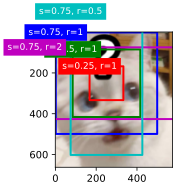

In [6]:
set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])


# IOU 交并比
衡量锚框好与不好的指标

Jaccard系数可以衡量两组之间的相似性，给定集合$\mathcal{A} \ and \ \mathcal{B}$，他们的Jaccard系数就是他们交集的大小除以他们并集的大小：
$$
J(A,B) = \frac{|\mathcal{A} \cap \mathcal{B}|}{|\mathcal{A} \cup \mathcal{B}|}
$$

很直观地，交并比的取值范围在0到1之间，像素也可以看做是一个集合。


In [7]:
def box_iou(boxes1,boxes2):
    """
    计算两个锚框或者边界框列表中成对的交并比(并行)
    返回的是(box1数量，box2数量)shape的Jaccard值
    """
    box_area = lambda boxes:((boxes[:,2]- boxes[:,0])*(boxes[:,3]- boxes[:,1]))
    # boxes1,boxes2,areas1,areas2的形状:
    # boxes1：(boxes1的数量,4),
    # boxes2：(boxes2的数量,4),
    # areas1：(boxes1的数量,),
    # areas2：(boxes2的数量,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # inter_upperlefts,inter_lowerrights,inters的形状:
    # (boxes1的数量,boxes2的数量,2)
    inter_upperlefts = t.max(boxes1[:,None,:2],boxes2[:,:2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights-inter_upperlefts).clamp(min=0)
    # inter_areas and union_areas的形状:(boxes1的数量,boxes2的数量)
    inter_areas = inters[:,:,0]*inters[:,:,1]
    union_areas = areas1[:,None]+areas2-inter_areas
    return inter_areas/union_areas


# 锚框标注
在训练集中，每一个锚框都是一个训练样本。为了训练目标检测模型，我们需要每个锚框的***类别和偏移量***标签。

在预测的时候，我们为每个图像生成多个锚框，预测所有的锚框的类别和偏移量，根据预测的偏移量调整它们的位置以获得预测的边界框，最后只输出符合特定条件的预测边界框。


In [8]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """将最接近的真实边界框分配给锚框"""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # 位于第i行和第j列的元素x_ij是锚框i和真实边界框j的IoU
    jaccard = box_iou(anchors, ground_truth)
    # 对于每个锚框，分配的真实边界框的张量
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # 根据阈值，决定是否分配真实边界框
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= 0.5).reshape(-1)
    box_j = indices[max_ious >= 0.5]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

## 标记类别和和偏移量
假设一个锚框A被分配了一个真实的边界B。A与B的类别将相同，另一方面A的偏移量将根据B和A中心坐标的相对位置以及两个框的相对大小进行标记。

鉴于数据集内的不同框的位置和大小不同，我们可以对那些相对位置和大小应用变换，使其获得更加均匀分布且易于拟合的偏移量，给定A和B，中心坐标分别为$(x_a,y_a),(x_b,y_b)$，宽度分别为$w_a,w_b$,高度分别为$h_a,h_b$,我们可以将偏移量标记为：
$$
\left( \frac{\frac{x_b-x_a}{w_a}-\mu_x}{\sigma_x},\frac{\frac{y_b-y_a}{h_a}-\mu_y}{\sigma_y},
\frac{\log \frac{w_b}{w_a}-\mu_w}{\sigma_w},\frac{\log \frac{h_b}{h_a}-\mu_h}{\sigma_h} \right)
$$
$$\mu_x = \mu_y = \mu_w =\mu_h = 0, \sigma_x = \sigma_y = 0.1, \sigma_w = \sigma_h =0.2$$

In [9]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """对锚框偏移量的转换"""
    c_anc = box_corner_to_center(anchors)
    c_assigned_bb = box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset


如果一个锚框没有被分配真实的边框，我们就需要把这个锚框标记为背景，它通常被称为负类锚框，而物体的锚框通常被称为正类的锚框。
我们使用真实边界框(labels 参数)实现multibox_target函数来标记锚框的类别和偏移量(anchors参数)

In [10]:
def multibox_target(anchors, labels):
    """使用真实边界框标记锚框"""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)
        # 将类标签和分配的边界框坐标初始化为零
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # 使用真实边界框来标记锚框的类别。
        # 如果一个锚框没有被分配，我们标记其为背景（值为零）
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # 偏移量转换
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)


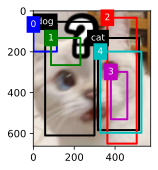

In [13]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                             [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                        [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                        [0.57, 0.3, 0.92, 0.9]])

fig =plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4'])


In [114]:
# 在这个函数里面做了batch并行，所以要增广一个batch维度才能输入进去
labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))


In [115]:
# 第2个变量是输入的锚框的类别
labels[2]


tensor([[0, 1, 2, 0, 2]])

In [116]:
# 第1个元素是掩码变量，形状为(batch_size,4*num_anchors)，为了过滤掉负类变量
labels[1]


tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

In [117]:
# 第0个元素是每个锚框的四个偏移值，负类锚框的偏移值是0
labels[0]


tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,  1.4000e+00,
          1.0000e+01,  2.5940e+00,  7.1754e+00, -1.2000e+00,  2.6882e-01,
          1.6824e+00, -1.5655e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -5.7143e-01, -1.0000e+00,  4.1723e-06,  6.2582e-01]])

# 使用非极大值抑制预测边界框(Non Maximum Suppression) 去掉冗余***预测***
- 每个锚框预测一个边缘框
- 合并相似的预测
    - 选中非背景类的最大预测值
    - 去掉所有其它的和IOU值大于$\theta$的预测
    - 重复上述过程知道所有预测要么被选中要么被去掉

In [118]:
def offset_inverse(anchors, offset_preds):
    """根据带有预测偏移量的锚框来预测边界框，\n
    该函数以锚框和偏移量预测作为输入，并应用逆偏移变换来返回预测的边界框坐标"""
    anc = box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = box_center_to_corner(pred_bbox)
    return predicted_bbox

当有许多的锚框的时候，我们有很多明显重叠的预测边界框，为了简化输出，可以使用非极大值抑制(Non-Maximum suppression, NMS)合并属于同一目标的类似的预测边界框。


In [119]:
def nms(boxes, scores, iou_threshold):
    """对预测边界框的置信度进行排序"""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # 保留预测边界框的指标
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1:
            break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)


In [120]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """使用非极大值抑制来预测边界框"""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        # 找到所有的non_keep索引，并将类设置为背景
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # pos_threshold是一个用于非背景预测的阈值
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)


In [121]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                        [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # 背景的预测概率
                          [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
                          [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率


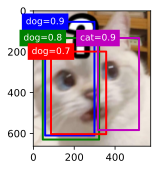

In [123]:
fig = plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

In [124]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output


tensor([[[ 0.0000,  0.9000,  0.1000,  0.0800,  0.5200,  0.9200],
         [ 1.0000,  0.9000,  0.5500,  0.2000,  0.9000,  0.8800],
         [-1.0000,  0.8000,  0.0800,  0.2000,  0.5600,  0.9500],
         [-1.0000,  0.7000,  0.1500,  0.3000,  0.6200,  0.9100]]])

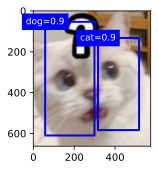

In [125]:
fig = plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

实践中，在执行非极大值抑制之前，我们可以将置信度较低的预测边界框溢出，从而减少计算量，也可以对非极大值抑制的输出进行处理（只保留置信度更高的结果作为最终输出）

因为锚框的存在，它的计算复杂度远远地大于图像分类这种任务
## 总结
- 以每个图像的每个像素为中心生成不同形状的锚框
- 使用IoU衡量锚框与GT的相似度
- 锚框的标签为目标检测的类别和锚框真实相对于边框的偏移量
- 在预测的时候使用NMS来移除类似的预测边界框，从而简化输出